In [2]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re
import itertools

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

### Load validation predicted probabilities

In [5]:
main_dir = '/tf/notebooks/'

In [6]:
probs_path = main_dir+'final-project/Classification/data/ethnicity'

In [7]:
test_pred_probs_mlp_ngram = np.load(os.path.join(probs_path, 'test_pred_probs_mlp_ngram.npy'))
test_pred_probs_cnn = np.load(os.path.join(probs_path, 'test_pred_probs_cnn.npy'))
test_pred_probs_cnn_aggr_chunk = np.load(os.path.join(probs_path, 'test_pred_probs_cnn_aggr_chunk.npy'))

In [8]:
len(test_pred_probs_mlp_ngram), len(test_pred_probs_cnn), len(test_pred_probs_cnn_aggr_chunk)

(62840, 62840, 62840)

In [9]:
with open(os.path.join(probs_path, 'test_ids'), 'rb') as fp:
    test_ids = pickle.load(fp)
with open(os.path.join(probs_path, 'test_target'), 'rb') as fp:
    test_target = pickle.load(fp)
with open(os.path.join(probs_path, 'test_list'), 'rb') as fp:
    test_list = pickle.load(fp)

In [10]:
len(test_ids), len(test_target), len(test_list)

(62840, 62840, 62840)

In [11]:
descr_df = pd.read_csv(main_dir+'final-project/data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(test_ids, dtype=int)]
descr_df.reset_index(inplace=True)
descr_df.shape

/usr/local/lib/python3.5/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(62840, 17)

In [12]:
pred_df = pd.DataFrame({'ids': np.asarray(test_ids, dtype=np.int64), 
                        'pred_probs_mlp_ngram': test_pred_probs_mlp_ngram.flatten(), 
                        'pred_probs_cnn': test_pred_probs_cnn.flatten(),
                        'pred_probs_cnn_chunk': test_pred_probs_cnn_aggr_chunk.flatten()})
pred_df.shape

(62840, 4)

In [13]:
pred_df.head()

,ids,pred_probs_cnn,pred_probs_cnn_chunk,pred_probs_mlp_ngram
0,980211229,0.699733,0.652895,0.780154
1,1120080577,0.599892,0.546952,0.298394
2,970087805,0.330026,0.622395,0.413196
3,1070071796,0.563146,0.620812,0.468336
4,1130075886,0.818220,0.639309,0.990493


In [14]:
descr_pred_df = descr_df.merge(pred_df, left_on='speech_id', right_on='ids')
descr_pred_df.shape

(62840, 21)

In [15]:
preds = [
    'pred_probs_mlp_ngram',
    'pred_probs_cnn', 
    'pred_probs_cnn_chunk'
]

In [16]:
descr_pred_df[preds+['Ethnicity']].groupby('Ethnicity').mean()

,pred_probs_mlp_ngram,pred_probs_cnn,pred_probs_cnn_chunk
Ethnicity,,,
AAPIA,0.622872,0.602833,0.567110
B,0.698588,0.657541,0.609150
B/AAPIA,0.648246,0.646355,0.589232
B/H,0.700518,0.675631,0.614712
H,0.630875,0.622599,0.579381
H/ME,0.267249,0.270426,0.363496
ME,0.557819,0.514673,0.499982
W,0.287612,0.317320,0.388145


In [17]:
descr_pred_df[preds+['NonWhite']].groupby('NonWhite').mean()

,pred_probs_mlp_ngram,pred_probs_cnn,pred_probs_cnn_chunk
NonWhite,,,
0.0,0.287612,0.317320,0.388145
1.0,0.653309,0.624304,0.583159


In [18]:
descr_pred_df['pred_probs_combo'] = descr_pred_df[preds].mean(axis=1)
descr_pred_df['pred_combo'] = descr_pred_df['pred_probs_combo'] > 0.5
np.mean(test_target==descr_pred_df['pred_combo'].values.flatten())

0.7653246339910885

### Save the main dataframe

In [19]:
keep_cols = ['speech_id',
 'date',
 'char_count',
 'word_count',
 'speakerid',
 'Party',
 'Congress',
 'Chamber',
 'State',
 'Ethnicity',
 'Age',
 'Age_lt_med',
 'NonWhite',
 'Female',
 'speaker',
 'Full Name',
 'match',
 'ids',
 'pred_probs_combo',
 'pred_combo']

In [20]:
descr_pred_df[keep_cols].to_pickle(os.path.join(probs_path, 'test_ethnicity_preds.pkl'))

### Evaluating final predictions

In [21]:
classes = ['White', 'NonWhite']

Confusion matrix, without normalization
[[26157  5263]
 [ 9484 21936]]
              precision    recall  f1-score   support

       White       0.73      0.83      0.78     31420
    NonWhite       0.81      0.70      0.75     31420

   micro avg       0.77      0.77      0.77     62840
   macro avg       0.77      0.77      0.76     62840
weighted avg       0.77      0.77      0.76     62840



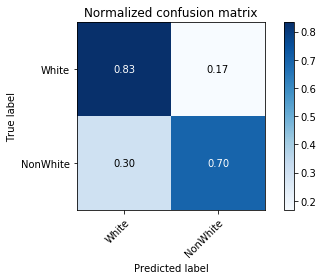

In [22]:
explore_data.plot_confusion_matrix(test_target, descr_pred_df['pred_combo'], classes, normalize=True)

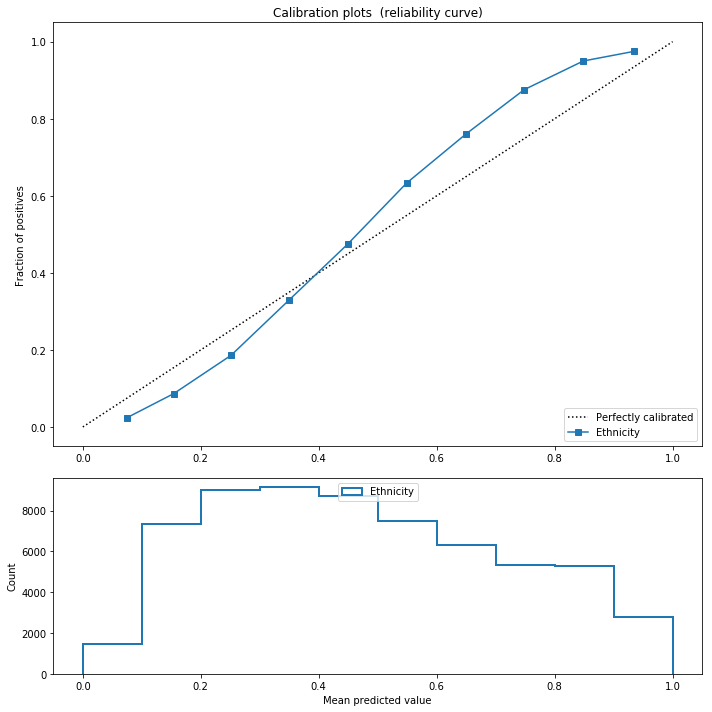

In [23]:
explore_data.plot_calibration_curve(test_target, descr_pred_df['pred_probs_combo'], 'Ethnicity')

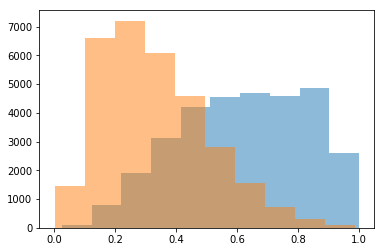

In [24]:
_=plt.hist(descr_pred_df[descr_pred_df.NonWhite==1]['pred_probs_combo'], alpha=0.5)
_=plt.hist(descr_pred_df[descr_pred_df.NonWhite==0]['pred_probs_combo'], alpha=0.5)
plt.show()

In [25]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(descr_pred_df['pred_probs_combo'], 
                                   test_ids, 
                                   descr_df.set_index('speech_id'))

Validation sample means:
      Gender_F  Ethinicity_NW    AvgAge   Party_D  Chamber_H  AvgWordCount
base   0.17508            0.5  58.34591  0.691168    0.69591    379.805617


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.39,0.40,0.99,0.77,0.66,1.08
0.6,0.98,1.10,0.99,1.03,1.21,0.84
1.0,1.85,1.74,1.01,1.29,1.29,1.03


In [26]:
reload(explore_data)
explore_data.compare_ngrams(test_list, descr_pred_df['pred_probs_combo'], 
                            ngram_range=(1, 1),
                            top_k=20)


Top 20 ngrams by differentiating score:


,ngram,<0.4,<0.6,<1.0,score
0,black,397.0,424.0,5707.0,607.0
1,african,212.0,344.0,3240.0,505.0
2,caucus,347.0,228.0,2417.0,487.0
3,consume,525.0,1232.0,1467.0,463.0
4,honor,2070.0,1572.0,3716.0,337.0
5,civil,1444.0,1268.0,3864.0,331.0
6,minorities,115.0,121.0,1189.0,325.0
7,printed,1710.0,412.0,283.0,320.0
8,city,2211.0,1687.0,5067.0,319.0
9,congressional,2972.0,1537.0,4360.0,311.0


## Congressperson level analysis

In [29]:
speaker_df = descr_pred_df[['Full Name', 'Party', 'State', 'Female', 'NonWhite', 'Age', 'pred_probs_combo', 'speech_id']]\
                .groupby(['Full Name', 'Party', 'State', 'Female', 'NonWhite'])\
                .agg({'pred_probs_combo':['mean'], 'Age': ['mean'], 'speech_id': ['count']})\
                .reset_index()
speaker_df.columns = ['_'.join(col) for col in speaker_df.columns]
speaker_df['NonWhite_pred_'] = speaker_df.pred_probs_combo_mean > 0.5
speaker_df.shape

(1710, 9)

Confusion matrix, without normalization
[[1265  219]
 [  32  194]]
              precision    recall  f1-score   support

       White       0.98      0.85      0.91      1484
    NonWhite       0.47      0.86      0.61       226

   micro avg       0.85      0.85      0.85      1710
   macro avg       0.72      0.86      0.76      1710
weighted avg       0.91      0.85      0.87      1710



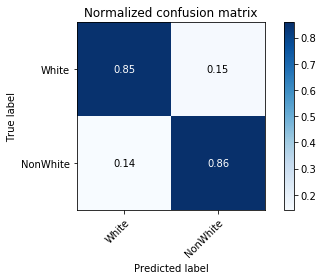

In [30]:
explore_data.plot_confusion_matrix(speaker_df.NonWhite_, speaker_df.NonWhite_pred_, classes, normalize=True)

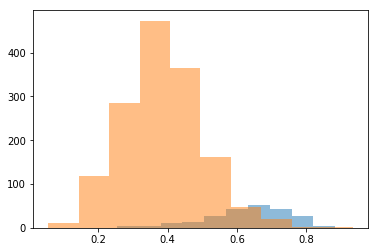

In [31]:
_=plt.hist(speaker_df[speaker_df.NonWhite_==1]['pred_probs_combo_mean'], alpha=0.5)
_=plt.hist(speaker_df[speaker_df.NonWhite_==0]['pred_probs_combo_mean'], alpha=0.5)
plt.show()

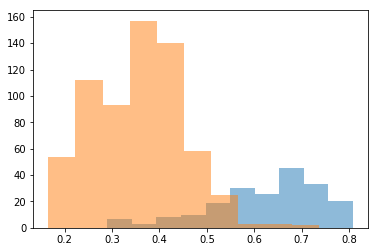

In [35]:
_=plt.hist(speaker_df[(speaker_df.NonWhite_==1) & (speaker_df.speech_id_count>speaker_df.speech_id_count.median())]['pred_probs_combo_mean'], alpha=0.5)
_=plt.hist(speaker_df[(speaker_df.NonWhite_==0) & (speaker_df.speech_id_count>speaker_df.speech_id_count.median())]['pred_probs_combo_mean'], alpha=0.5)
plt.show()

In [38]:
speaker_med_df = speaker_df[speaker_df.speech_id_count > speaker_df.speech_id_count.median()]
speaker_med_df.shape

(848, 9)

Confusion matrix, without normalization
[[605  42]
 [ 28 173]]
              precision    recall  f1-score   support

       White       0.96      0.94      0.95       647
    NonWhite       0.80      0.86      0.83       201

   micro avg       0.92      0.92      0.92       848
   macro avg       0.88      0.90      0.89       848
weighted avg       0.92      0.92      0.92       848



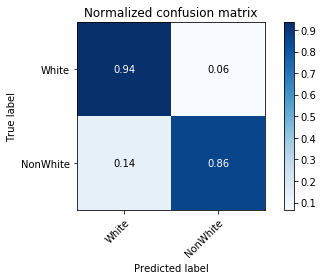

In [39]:
explore_data.plot_confusion_matrix(speaker_med_df.NonWhite_, speaker_med_df.NonWhite_pred_, classes, normalize=True)

In [40]:
tp = np.argmax(speaker_med_df[speaker_med_df.NonWhite_==1].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.NonWhite_==1].iloc[tp]

Full Name_               HALL, KATIE
Party_                             D
State_                            IN
Female_                            1
NonWhite_                          1
speech_id_count                   46
pred_probs_combo_mean       0.807885
Age_mean                          46
NonWhite_pred_                  True
Name: 678, dtype: object

In [41]:
tn = np.argmin(speaker_med_df[speaker_med_df.NonWhite_==0].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.NonWhite_==0].iloc[tn]

Full Name_               BARRASSO, JOHN
Party_                                R
State_                               WY
Female_                               0
NonWhite_                             0
speech_id_count                      16
pred_probs_combo_mean          0.165778
Age_mean                         60.875
NonWhite_pred_                    False
Name: 71, dtype: object

In [42]:
fp = np.argmax(speaker_med_df[speaker_med_df.NonWhite_==0].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.NonWhite_==0].iloc[fp]

Full Name_               BORDALLO, MADELEINE
Party_                                     D
State_                                    GU
Female_                                    1
NonWhite_                                  0
speech_id_count                           18
pred_probs_combo_mean               0.736895
Age_mean                             75.2222
NonWhite_pred_                          True
Name: 153, dtype: object

In [43]:
fn = np.argmin(speaker_med_df[speaker_med_df.NonWhite_==1].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.NonWhite_==1].iloc[fn]

Full Name_               MOONEY, ALEX
Party_                              R
State_                             WV
Female_                             0
NonWhite_                           1
speech_id_count                    12
pred_probs_combo_mean        0.290235
Age_mean                           45
NonWhite_pred_                  False
Name: 1128, dtype: object

## Congress level analysis

In [44]:
congress_df = descr_pred_df[['Congress', 'NonWhite', 'pred_probs_combo', 'pred_combo']]\
                .groupby('Congress')\
                .agg({'NonWhite': ['mean', 'sum'], 'pred_combo': ['mean']})\
                .reset_index()
congress_df.columns = ['_'.join(col) for col in congress_df.columns]
congress_df['Prediction_balance'] = congress_df.pred_combo_mean / congress_df.NonWhite_mean
congress_df.shape

(18, 5)

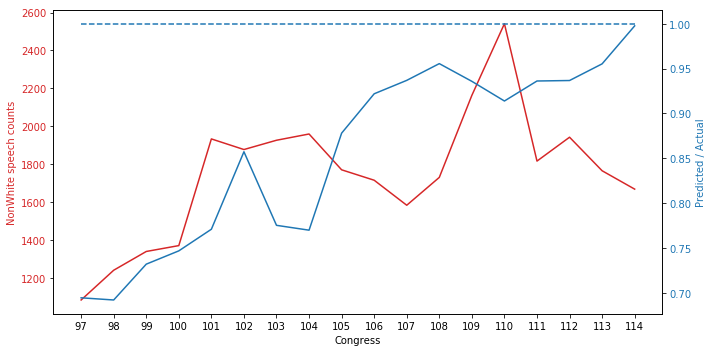

In [45]:
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('Congress')
ax1.set_ylabel('NonWhite speech counts', color=color)
ax1.plot(congress_df.Congress_, congress_df.NonWhite_sum, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Predicted / Actual', color=color)  # we already handled the x-label with ax1
ax2.plot(congress_df.Congress_, congress_df.Prediction_balance, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.hlines(y=1,xmin=97,xmax=114, color=color, linestyles='dashed')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(range(97,115))
plt.show()